In [1]:
Titanic-Dataset.csv.xls

NameError: name 'Titanic' is not defined

In [2]:
pip install kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 2.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
mkdir -p ~/.kaggle
mv ~/Downloads/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json


SyntaxError: invalid syntax (3459799299.py, line 1)

In [5]:
!mkdir -p ~/.kaggle
!mv ~/Downloads/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
kaggle competitions download -c titanic


SyntaxError: invalid syntax (4268795547.py, line 1)

In [9]:
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 70.5MB/s]


In [10]:
unzip titanic.zip -d ~/Documents/ml_task1/

SyntaxError: invalid syntax (4191590558.py, line 1)

In [11]:
!unzip titanic.zip -d ~/Documents/ml_task1/

Archive:  titanic.zip
  inflating: /Users/shreshta/Documents/ml_task1//gender_submission.csv  
  inflating: /Users/shreshta/Documents/ml_task1//test.csv  
  inflating: /Users/shreshta/Documents/ml_task1//train.csv  


In [14]:
!cd ~/Documents/ml_task1
!ls


gender_submission.csv     test.csv                  venv
ml_task1                  titanic.zip
task1_data_cleaning.ipynb train.csv


In [16]:
# task1_data_cleaning.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load dataset (adjust filename if needed)
df = pd.read_csv('train.csv')   # or 'train.csv' depending on file
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
# Numeric imputer: median for 'Age'
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Example: fill Age with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# For Embarked (categorical) - fill with mode
if 'Embarked' in df.columns:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Cabin has lots of missing values -> we will drop or extract deck
if 'Cabin' in df.columns:
    df['Cabin'] = df['Cabin'].fillna('Unknown')
    df['Deck'] = df['Cabin'].apply(lambda x: str(x)[0])  # first letter


In [18]:
# Example: one-hot encode Sex, Embarked, Deck (if created)
df = pd.get_dummies(df, columns=[c for c in ['Sex','Embarked','Deck'] if c in df.columns], drop_first=True)


In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_features = ['Age','Fare','SibSp','Parch']  # adjust to dataset
cat_features = ['Sex','Embarked','Deck']      # adjust to dataset

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, [c for c in num_features if c in df.columns]),
    ('cat', cat_transformer, [c for c in cat_features if c in df.columns])
])

# Fit and transform (example using features only)
features = [c for c in (num_features+cat_features) if c in df.columns]
X = preprocessor.fit_transform(df[features])
print("Transformed shape:", X.shape)


Transformed shape: (891, 4)


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Fare_scaled'] = scaler.fit_transform(df[['Fare']])


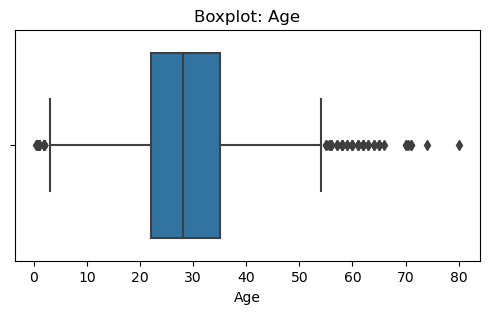

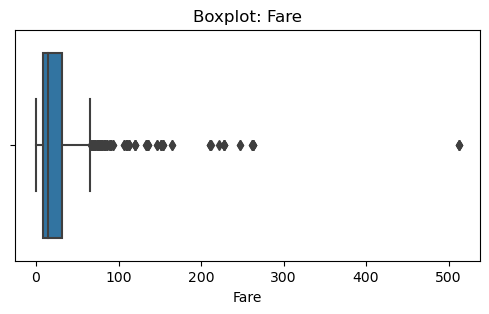

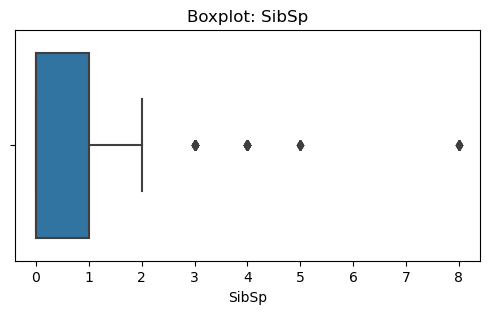

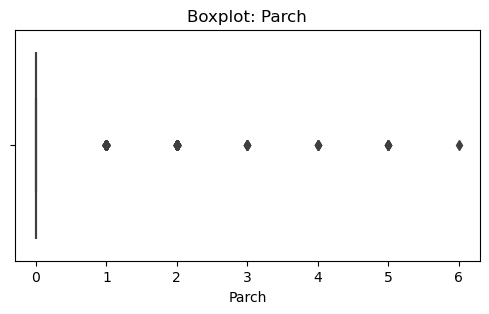

In [21]:
# Boxplot for numeric columns
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['Age','Fare','SibSp','Parch']:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot: {col}')
        plt.show()


In [22]:
# IQR method
def remove_outliers_iqr(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

if 'Fare' in df.columns:
    df_no_out = remove_outliers_iqr(df, 'Fare')
    print("Removed rows:", df.shape[0] - df_no_out.shape[0])
    df = df_no_out  # replace with outlier-removed df


Removed rows: 116


In [23]:
df.to_csv('titanic_cleaned.csv', index=False)


In [ ]:
!git init
!git add .
!git commit -m "Task1: data cleaning and preprocessing - initial"


You have not agreed to the Xcode and Apple SDKs license. You must agree to the license below in order to use Xcode.
Press enter to display the license:
